# Мини-проект ВВП Ганы

In [3]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model
from sklearn.linear_model import LinearRegression

pd.options.display.float_format ='{:.3f}'.format

#### 1.1 Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

#### Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [4]:
data = pd.read_csv('ghana_gdp.csv')
data['year'] = pd.to_datetime(data['year'])

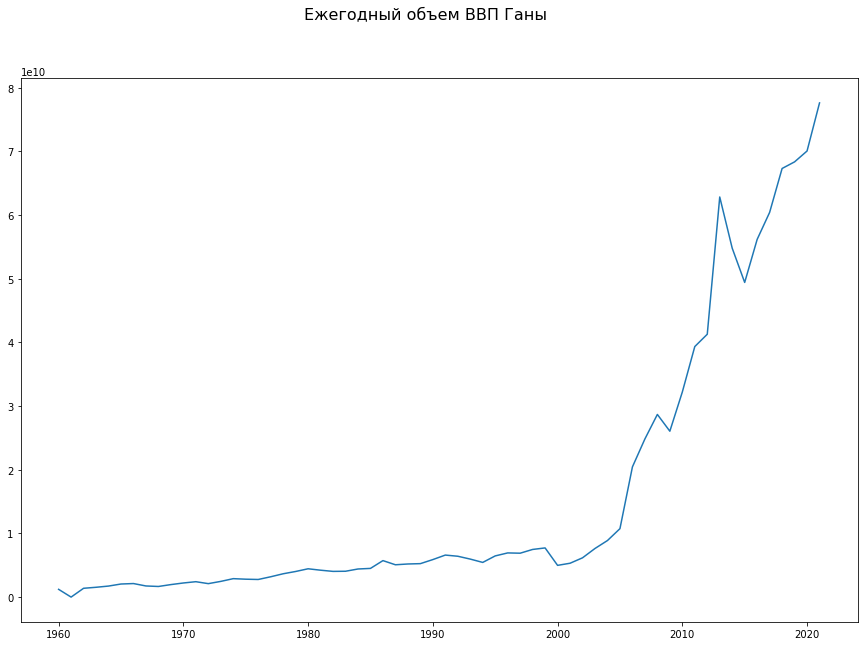

In [5]:
data_ghana = data.copy()
data_ghana['year'] = pd.to_datetime(data_ghana['year']).dt.year
data_ghana = data_ghana.set_index('year')

plt.figure(figsize=(15, 10))
plt.plot(data_ghana)
plt.suptitle('Ежегодный объем ВВП Ганы', size=16)
plt.show();

*Первоначальный визуальный анализ позволяет сказать о наличии во временном ряде восходящего тренда и отсутствии явных признаков сезонности. Хотя тут корректнее будет говорить скорее о периодичности, нежели сезонности, так как представлены ежегодные данные.*

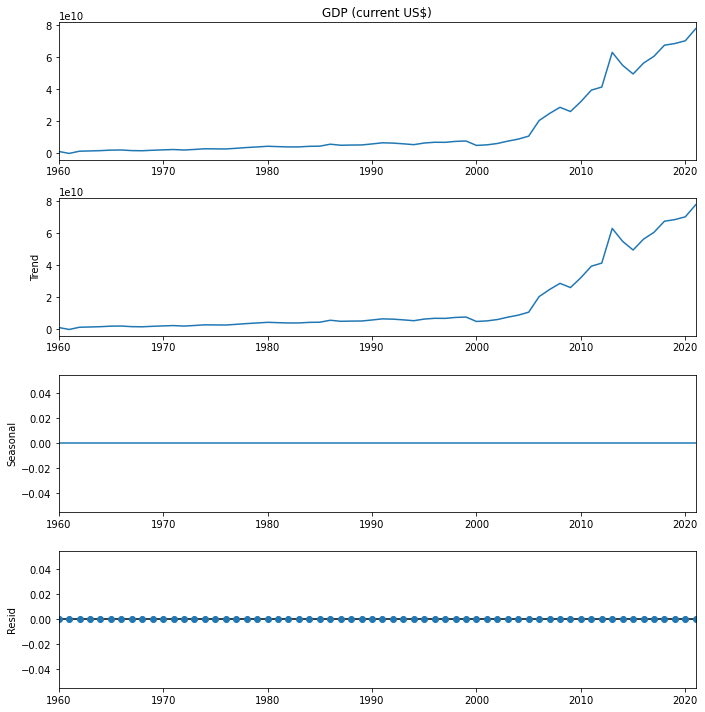

In [6]:
# проверим свое предположение средствами декомпозиции ряда:
plt.rcParams["figure.figsize"] = 10, 10

data = data.set_index('year')
result = seasonal_decompose(data['GDP (current US$)'])
result.plot()
plt.show()

In [7]:
# отложим последние три года как тестовую выборку для оценки результатов:
test_df = data_ghana.iloc[-3:]
train_df = data_ghana.iloc[:-3]

#### 1.2 Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

#### Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

In [8]:
def predict_ma(data, window, predict_count):
    data = list(data.rolling(window=5).mean())

    for i in range(predict_count):
        prediction = statistics.mean(data[-window:])
        data.append(prediction)

    return data[-predict_count:]

prediction_list = predict_ma(train_df['GDP (current US$)'], 4, 3)

prediction_ma = pd.DataFrame({'year': test_df.index, 'GDP (current US$)': prediction_list})
prediction_ma = prediction_ma.set_index('year')

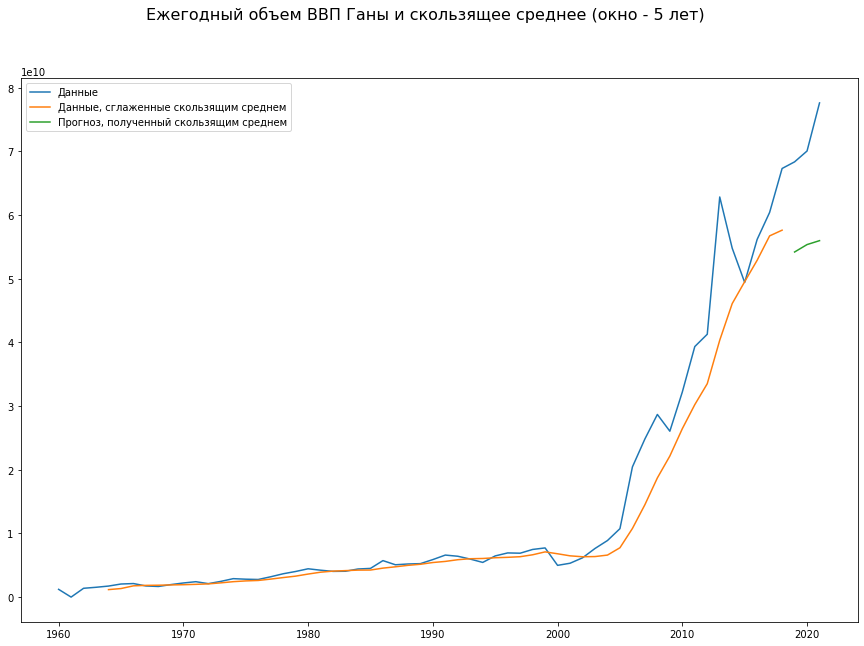

In [9]:
train_df_ma = train_df.rolling(window=5).mean()

plt.figure(figsize=(15, 10))
plt.plot(data_ghana, label='Данные')
plt.plot(train_df_ma, label='Данные, сглаженные скользящим среднем')
plt.plot(prediction_ma, label='Прогноз, полученный скользящим среднем')
plt.legend()

plt.suptitle('Ежегодный объем ВВП Ганы и скользящее среднее (окно - 5 лет)', size=16)
plt.show();

*При помощи скользящего среднего можно отчетливее проследить восходящую тенденцию, сгладив некоторые провалы, которые явно не имеют циклический характер.*

*Наивный прогноз, полученный этим способом, улавливает восходящий тренд в ряду данных, но результат все же довольно далек от реальных показателей.*

#### 1.3 С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

#### Параметры p и q выберите по коррелограммам ACF и PACF.

#### Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда. Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [10]:
test_adfuller = adfuller(train_df['GDP (current US$)'])
print("adf: ", test_adfuller[0])
print("p-value: ", test_adfuller[1])
print("Critical values: ", test_adfuller[4])
if test_adfuller[0] > test_adfuller[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885412
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


*Ds  Так как ряд не стационарен выбираем модель ARIMA*

In [11]:
# подбираем параметр p, дифференцируя ряд до его стационарности:

row = train_df['GDP (current US$)']
d = 1

while True:
    row = row.diff().dropna()
    test_adfuller = adfuller(row)
    if test_adfuller[0] > test_adfuller[4]['5%']:
        print(f'При интегрировании ряда {d} порядка, ряд не стационарен')
        d += 1

    else:
        print(f'При интегрировании ряда {d} порядка, ряд стационарен')
        break

При интегрировании ряда 1 порядка, ряд не стационарен
При интегрировании ряда 2 порядка, ряд не стационарен
При интегрировании ряда 3 порядка, ряд стационарен


In [12]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0])
    sgt.plot_pacf(series, ax=axes[1], method="ywm")
    plt.show()

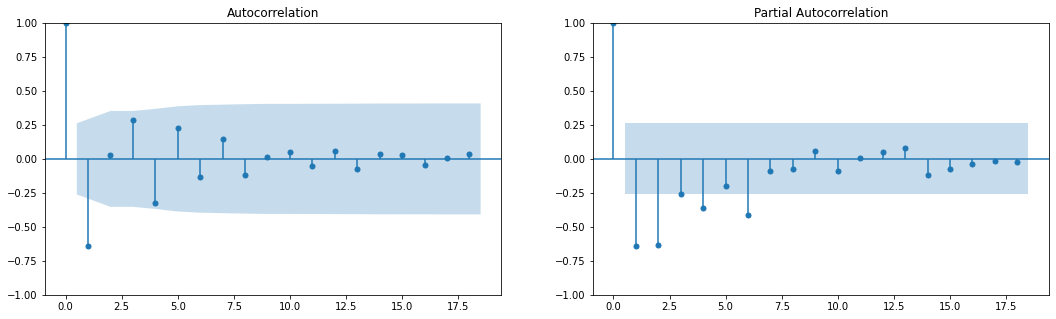

In [13]:
plot_acf_pacf(row)

По pacf видим что последним лагом, отличным от нуля является 6 лаг.

In [14]:
p = 6
q = 5

In [15]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 5)   Log Likelihood               -1302.392
Date:                Sun, 26 Mar 2023   AIC                           2628.785
Time:                        18:48:27   BIC                           2653.089
Sample:                             0   HQIC                          2638.207
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4636      0.396     -3.699      0.000      -2.239      -0.688
ar.L2         -1.9122      0.393     -4.862      0.000      -2.683      -1.141
ar.L3         -1.9362      0.624     -3.102      0.002      -3.159      -0.713
ar.L4         -1.7615      0.550     -3.205      0.001      -2.839      -0.684
ar.L5         -1.2653      0.707     -1.789      0.074      -2.651       0.121
ar.L6         -0.8338      0.247     -3.376      0.001      -1.318      -0.350
ma.L1         -0.4028      0.348     -1.158      0.247      -1.084       0.279
ma.L2         -0.1193      0.866     -0.138      0.890      -1.816       1.577
ma.L3          0.1161      0.677      0.172      0.864      -1.211       1.443
ma.L4         -0.7353      0.672     -1.095      0.274      -2.052       0.581
ma.L5          0.2155      0.897      0.240      0.810      -1.542       1.973
sigma2       1.03e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                36.31
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              54.69   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.5e+54. Standard errors may be unstable.
"""

In [16]:
smodel = pm.auto_arima(
    train_df,
    start_p=4,
    start_q=4,
    d=3,
    max_p=10,
    max_q=10,
    m=1,
    D=1,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(4,3,4)(0,0,0)[0]             : AIC=2646.490, Time=0.36 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.02 sec
 ARIMA(3,3,4)(0,0,0)[0]             : AIC=2652.777, Time=0.18 sec
 ARIMA(4,3,3)(0,0,0)[0]             : AIC=2649.147, Time=0.15 sec
 ARIMA(5,3,4)(0,0,0)[0]             : AIC=2643.542, Time=0.31 sec
 ARIMA(5,3,3)(0,0,0)[0]             : AIC=2647.080, Time=0.16 sec
 ARIMA(6,3,4)(0,0,0)[0]             : AIC=2626.067, Time=0.41 sec
 ARIMA(6,3,3)(0,0,0)[0]             : AIC=2628.797, Time=0.32 sec
 ARIMA(7,3,4)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(6,3,5)(0,0,0)[0]             : AIC=2628.785, Time=0.64 sec
 ARIMA(5,3,5)(0,0,0)[0]             : AIC=2646.752, Time=0.51 sec
 ARIMA(7,3,3)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(7,3,5)(0,0,0)[0]             : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(6, 3, 4)   Log Likelihood               -1302.033
Date:                Sun, 26 Mar 2023   AIC                           2626.067
Time:                        18:48:32   BIC                           2648.345
Sample:                             0   HQIC                          2634.704
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5617      0.157     -9.916      0.000      -1.870      -1.253
ar.L2         -2.0538      0.352     -5.830      0.000      -2.744      -1.363
ar.L3         -2.1140      0.473     -4.471      0.000      -3.041      -1.187
ar.L4         -1.9494      0.353     -5.526      0.000      -2.641      -1.258
ar.L5         -1.3967      0.235     -5.942      0.000      -1.857      -0.936
ar.L6         -0.8753      0.174     -5.017      0.000      -1.217      -0.533
ma.L1         -0.2256      0.276     -0.818      0.413      -0.766       0.315
ma.L2         -0.1493      0.383     -0.390      0.696      -0.899       0.601
ma.L3          0.1292      0.334      0.387      0.699      -0.525       0.784
ma.L4         -0.7015      0.357     -1.964      0.049      -1.402      -0.002
sigma2      9.106e+18        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                43.67
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):              46.43   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+53. Standard errors may be unstable.
"""

*Лучшие параметры практически совпадают с подобранными ранее.*

#### 1.4 Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [17]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(6, 3, 4))
arima_model_fit = arima_model.fit()

/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

In [18]:
arima_pred = arima_model_fit.predict(start=len(train_df), end=len(data_ghana)-1)
prediction_arima = pd.DataFrame({'year': test_df.index,
                                 'GDP (current US$)': arima_pred})
prediction_arima = prediction_arima.set_index('year')
prediction_arima

/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,GDP (current US$)
year,
2019,66616048527.644
2020,75991848095.000
2021,64197702376.085


#### 1.5 Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

In [19]:
prediction_arima_ci = arima_model_fit.conf_int(alpha=0.05)

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

prediction_arima['lower GDP (current US$)'] = list(forecast_df['lower GDP (current US$)'])
prediction_arima['upper GDP (current US$)'] = list(forecast_df['upper GDP (current US$)'])

prediction_arima

/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,GDP (current US$),lower GDP (current US$),upper GDP (current US$)
year,,,
2019,66616048527.644,60685119375.486,72546977679.802
2020,75991848095.000,66645561259.255,85338134930.744
2021,64197702376.085,52313631139.489,76081773612.680


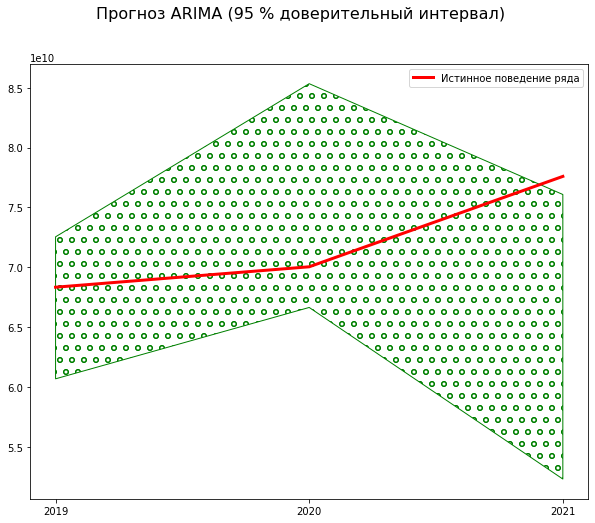

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
plt.plot(test_df,
         color='red',
         linewidth=3,
         label='Истинное поведение ряда')
plt.fill_between(prediction_arima.index,
                 prediction_arima['lower GDP (current US$)'],
                 prediction_arima['upper GDP (current US$)'],
                 color='none',
                 hatch='o',
                 edgecolor='g')
ax.set_xticks(prediction_arima.index)
plt.legend()
plt.suptitle('Прогноз ARIMA (95 % доверительный интервал)', size=16)
plt.show();

#### 1.6 Сделайте выводы по полученным результатам.

### *ВЫВОД: С учетом доверительного и интервала прогноз модели ARIMA с подобранными параметрами формирует область значений в которую входит и истинные данные. Модель не уловила направление движения ряда, но, учитывая отсутствие закономерности колебаний данных - это предсказуемо.*

#### 2.1 Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц.

In [21]:
data.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1217086834.734
1961-01-01,0.000
1962-01-01,1382352941.176
1963-01-01,1540616246.499
1964-01-01,1731092436.975
...,...
2017-01-01,60406382898.517
2018-01-01,67299280679.563
2019-01-01,68337537815.770


Пропуски в датах отсутствуют.

#### 2.2 Проверьте данные на наличие пропущенных значений.

In [22]:
print(f'Количество явных пропусков: {data_ghana["GDP (current US$)"].isna().sum()}')

Количество явных пропусков: 0


#### 2.3 Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN.

In [23]:
data_ghana['GDP (current US$)'][data_ghana['GDP (current US$)'] == 0]

year
1961   0.000
Name: GDP (current US$), dtype: float64

In [24]:
data_ghana['GDP (current US$)'] = data_ghana['GDP (current US$)'].apply(
    lambda x: np.nan if x==0 else x)

data_ghana['GDP (current US$)'][data_ghana['GDP (current US$)'].isnull()]

year
1961   NaN
Name: GDP (current US$), dtype: float64

#### 2.4 Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

In [25]:
data_ghana['GDP (current US$)'] = data_ghana['GDP (current US$)'].interpolate(method='linear')

In [26]:
data_ghana[:3]

,GDP (current US$)
year,
1960,1217086834.734
1961,1299719887.955
1962,1382352941.176


#### 2.5 Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [27]:
# отложим последние три года как тестовую выборку для оценки результатов:
test_df = data_ghana.iloc[-3:]
train_df = data_ghana.iloc[:-3]

# проверяем на стационарность:
test_adfuller = adfuller(train_df['GDP (current US$)'])
print("adf: ", test_adfuller[0])
print("p-value: ", test_adfuller[1])
print("Critical values: ", test_adfuller[4])
if test_adfuller[0] > test_adfuller[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.8030073326980112
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [28]:
# подбираем параметр p, дифференцируя ряд до его стационарности:

row = train_df['GDP (current US$)']
d = 1

while True:
    row = row.diff().dropna()
    test_adfuller = adfuller(row)
    if test_adfuller[0] > test_adfuller[4]['5%']:
        print(f'При интегрировании ряда {d} порядка, ряд не стационарен')
        d += 1

    else:
        print(f'При интегрировании ряда {d} порядка, ряд стационарен')
        break

При интегрировании ряда 1 порядка, ряд не стационарен
При интегрировании ряда 2 порядка, ряд не стационарен
При интегрировании ряда 3 порядка, ряд стационарен


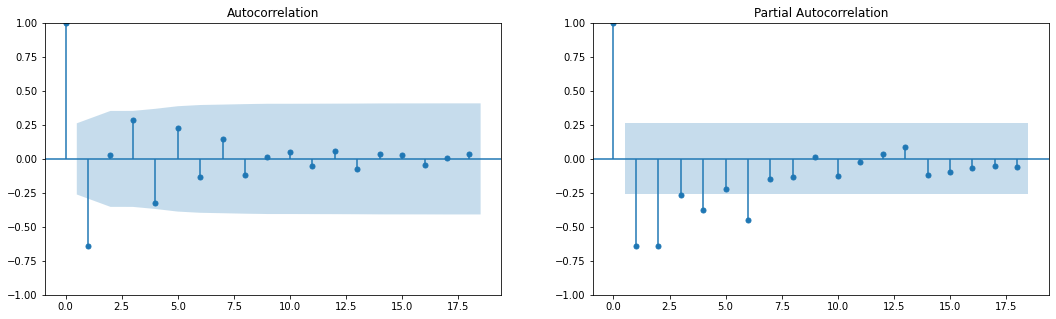

In [29]:
plot_acf_pacf(row)

При анализе на стационарность и автоколлинеарность - показатели практически не изменились. Запустим модель ARIMA c параметрами, подобранными на предыдущем шаге:

In [30]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(6, 3, 4))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 4)   Log Likelihood               -1301.497
Date:                Sun, 26 Mar 2023   AIC                           2624.994
Time:                        18:48:34   BIC                           2647.272
Sample:                             0   HQIC                          2633.631
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5594      0.183     -8.532      0.000      -1.918      -1.201
ar.L2         -2.0427      0.386     -5.292      0.000      -2.799      -1.286
ar.L3         -2.1076      0.485     -4.344      0.000      -3.059      -1.157
ar.L4         -1.9555      0.360     -5.428      0.000      -2.662      -1.249
ar.L5         -1.4050      0.223     -6.312      0.000      -1.841      -0.969
ar.L6         -0.8773      0.185     -4.736      0.000      -1.240      -0.514
ma.L1         -0.1989      0.287     -0.694      0.488      -0.761       0.363
ma.L2         -0.2133      0.433     -0.492      0.623      -1.063       0.636
ma.L3          0.1676      0.397      0.422      0.673      -0.611       0.946
ma.L4         -0.7072      0.389     -1.820      0.069      -1.469       0.054
sigma2      9.049e+18        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                47.78
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):              98.00   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.39e+53. Standard errors may be unstable.
"""

In [31]:
arima_pred_int = arima_model_fit.predict(start=len(train_df), end=len(data_ghana)-1)
prediction_arima_int = pd.DataFrame({'year': test_df.index,
                                 'GDP (current US$)': arima_pred})
prediction_arima_int = prediction_arima_int.set_index('year')

/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [32]:
# сравним предсказания:
prediction_arima

,GDP (current US$),lower GDP (current US$),upper GDP (current US$)
year,,,
2019,66616048527.644,60685119375.486,72546977679.802
2020,75991848095.000,66645561259.255,85338134930.744
2021,64197702376.085,52313631139.489,76081773612.680


In [33]:
prediction_arima_int

,GDP (current US$)
year,
2019,66616048527.644
2020,75991848095.000
2021,64197702376.085


#### 2.6 Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

### *ВЫВОД: Интерполяция не сильно повлияла на показатели модели, в частности критерий AIC изменился совсем незначительно, а прогноз не изменился вовсе. Это объяснимо и очевидно; пропущенное значение, было единственным и находилось в самом начале ряда данных. Его заполнение значимо не повлияло на показатели модели и прогноз для периода, находящегося на значительном временном удалении от пропуска.*

#### 3.1 Посчитайте волатильность для вашего временного ряда.

In [34]:
data_ghana['GDP_vol'] = data_ghana['GDP (current US$)'].pct_change(1).mul(100).abs()
data_ghana['GDP_vol'].head()

year
1960      NaN
1961    6.789
1962    6.358
1963   11.449
1964   12.364
Name: GDP_vol, dtype: float64

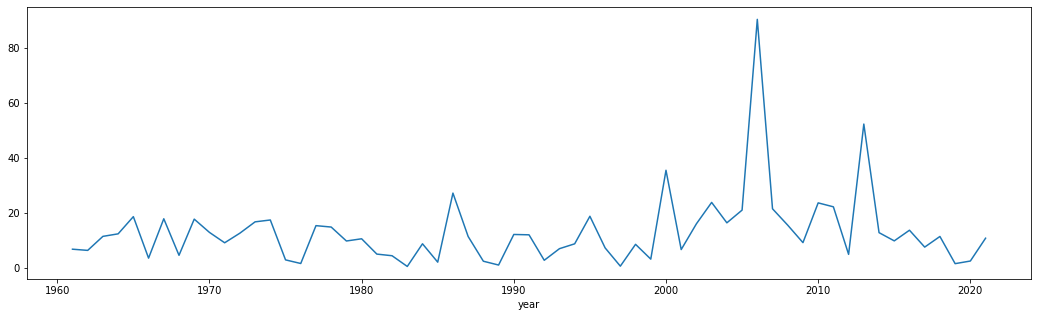

In [35]:
data_ghana['GDP_vol'].plot()
plt.show()

#### 3.2 Используйте GARCH-модель для предсказания волатильности.

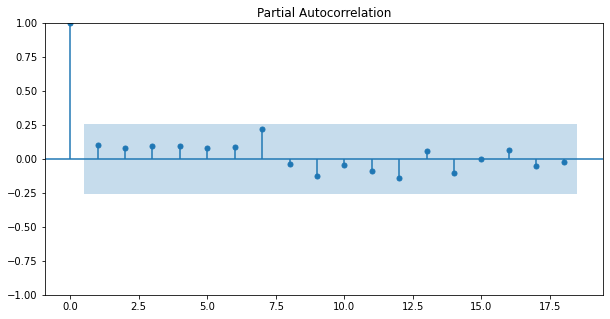

In [36]:
test_df = data_ghana.iloc[-3:]
train_df = data_ghana.iloc[:-3]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df['GDP_vol'][1:], method="ywm")
plt.show()

Самый значимый лаг - 7.

In [37]:
test_adfuller = adfuller(train_df['GDP_vol'][1:])
print("adf: ", test_adfuller[0])
print("p-value: ", test_adfuller[1])
print("Critical values: ", test_adfuller[4])
if test_adfuller[0] > test_adfuller[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


In [38]:
train_df = pd.DataFrame(train_df['GDP_vol'].loc[train_df.index])

train_df

,GDP_vol
year,
1960,NaN
1961,6.789
1962,6.358
1963,11.449
1964,12.364
1965,18.608
1966,3.547
1967,17.838
1968,4.574


In [39]:
model = arch_model(train_df['GDP_vol'].dropna(), vol='GARCH', p=7, q=3)

In [40]:
model_results = model.fit()
model_results.summary()

Iteration:      1,   Func. Count:     14,   Neg. LLF: 230.85997807162335
Iteration:      2,   Func. Count:     31,   Neg. LLF: 229.1369274938817
Iteration:      3,   Func. Count:     44,   Neg. LLF: 223.89033047243177
Iteration:      4,   Func. Count:     57,   Neg. LLF: 314.2958322246358
Iteration:      5,   Func. Count:     71,   Neg. LLF: 225.10855989257388
Iteration:      6,   Func. Count:     85,   Neg. LLF: 214.6966446686007
Iteration:      7,   Func. Count:     98,   Neg. LLF: 214.58603812906534
Iteration:      8,   Func. Count:    111,   Neg. LLF: 220.11244719193053
Iteration:      9,   Func. Count:    127,   Neg. LLF: 214.0478636238677
Iteration:     10,   Func. Count:    140,   Neg. LLF: 213.8984688540349
Iteration:     11,   Func. Count:    153,   Neg. LLF: 213.8800906844818
Iteration:     12,   Func. Count:    166,   Neg. LLF: 213.84701997337194
Iteration:     13,   Func. Count:    179,   Neg. LLF: 248.89750290116632
Iteration:     14,   Func. Count:    194,   Neg. LLF: 271

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -213.551
Distribution:                  Normal   AIC:                           451.101
Method:            Maximum Likelihood   BIC:                           475.827
                                        No. Observations:                   58
Date:                Sun, Mar 26 2023   Df Residuals:                       57
Time:                        18:48:35   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.0951      0.834     13.298  2.387e-40 [  9.460, 12.730]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         24.5284     23.708      1.035      0.301      [-21.938, 70.995]
alpha[1]   1.5466e-11  5.666e-03  2.730e-09      1.000 [-1.111e-02,1.111e-02]
alpha[2]   1.0028e-10  2.061e-02  4.866e-09      1.000 [-4.039e-02,4.039e-02]
alpha[3]       0.3635      0.317      1.146      0.252      [ -0.258,  0.985]
alpha[4]   3.8224e-04      0.288  1.327e-03      0.999      [ -0.564,  0.565]
alpha[5]       0.0000  3.217e-02      0.000      1.000 [-6.305e-02,6.305e-02]
alpha[6]       0.5533      0.282      1.959  5.007e-02   [-1.691e-04,  1.107]
alpha[7]       0.0828      0.526      0.157      0.875      [ -0.949,  1.114]
beta[1]    1.0014e-12      0.796  1.258e-12      1.000      [ -1.560,  1.560]
beta[2]    4.5439e-11  8.107e-02  5.605e-10      1.000      [ -0.159,  0.159]
beta[3]    7.3825e-11  2.168e-02  3.405e-09      1.000 [-4.250e-02,4.250e-02]
=============================================================================

Covariance estimator: robust
"""

In [41]:
predictions_df = test_df.copy()
results = model_results.forecast(horizon=3)

/Users/margaritakravchenko/Desktop/sF_projects/venv/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [42]:
results_df = pd.DataFrame(results.variance.values[-1, :])
results_df['year'] = test_df.index
results_df = results_df.set_index('year')
results_df

,0
year,
2019,965.918
2020,170.798
2021,25.718


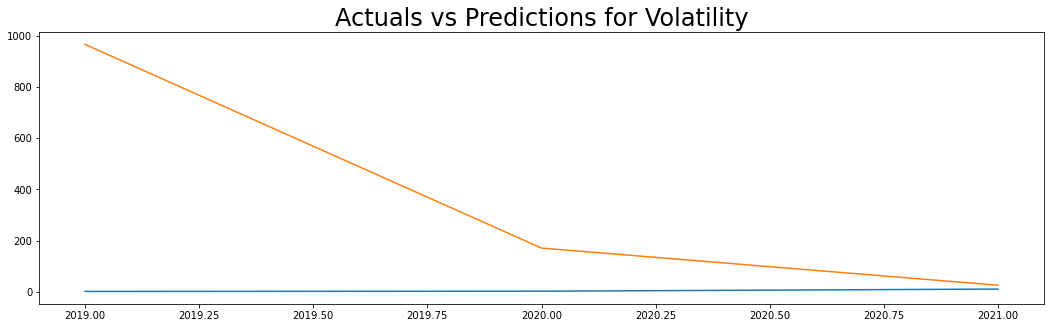

In [43]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df['GDP_vol'].abs())
plt.plot(results_df[0])

plt.title("Actuals vs Predictions for Volatility", size=24)

plt.show()

#### 3.3 Используйте линейную регрессию для получения прогноза.

In [44]:
X_train = pd.DataFrame(range(data_ghana["GDP_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data_ghana["GDP_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP_vol"].fillna(0)
y_test = test_df["GDP_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


#### 3.4 Визуализируйте полученное предсказание вместе с фактическим значением.

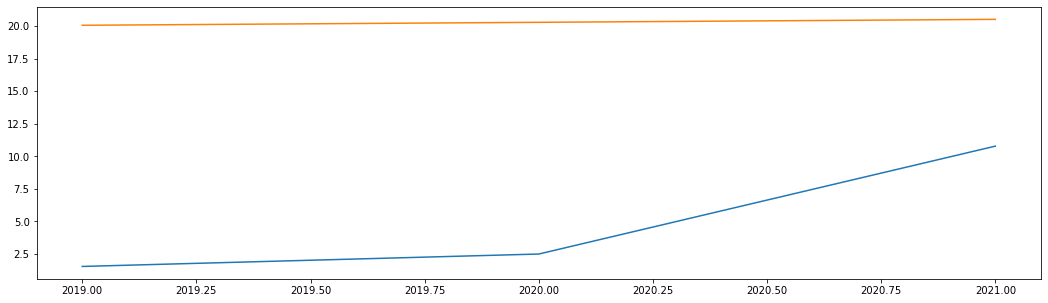

In [45]:
plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

#### 3.5 Сравните результаты и сделайте выводы.
#### 3.6 Почему результат модели GARCH получился именно таким?

Судя по полученным графикам, модели не уловили дисперсию, так как такое поведение было для них новым и подобные случаи отсутствовали в обучающей выборке. Скорее всего в тестовой выборке было слишком мало данных, и на последний период пришлись наиболее значимые скачки в показателях ВВП.